In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [2]:
df = pd.read_csv('data.csv')
df.columns = ['date', 'volumn', 'amount', 'start_price', 'max_price', 'min_price', 'end_price', 'delta', 'count']
df.head()

,date,volumn,amount,start_price,max_price,min_price,end_price,delta,count
0,105/01/04,"3,564,019","16,956,319",4.80,4.84,4.68,4.69,-0.09,924
1,105/01/05,"2,504,182","11,692,096",4.69,4.74,4.62,4.63,-0.06,752
2,105/01/06,"4,528,184","20,886,563",4.63,4.69,4.57,4.60,-0.03,"1,073"
3,105/01/07,"6,462,223","29,128,814",4.60,4.63,4.45,4.49,-0.11,"1,275"
4,105/01/08,"3,729,252","16,547,177",4.32,4.49,4.32,4.49,0.00,829


In [3]:
def transform_year_format(year):
    year_list = year.split('/')
    year_list[0] = str(int(year_list[0]) + 1911)
    transform_year = '/'.join(year_list)
    
    return transform_year

df['date'] = pd.to_datetime(df['date'].apply(transform_year_format))
df['year'] = [x.year for x in df['date']]
df['month'] = [x.month for x in df['date']]
df['day'] = [x.day for x in df['date']]
df['weekday'] = [x.weekday() for x in df['date']]

<AxesSubplot:xlabel='date', ylabel='end_price'>

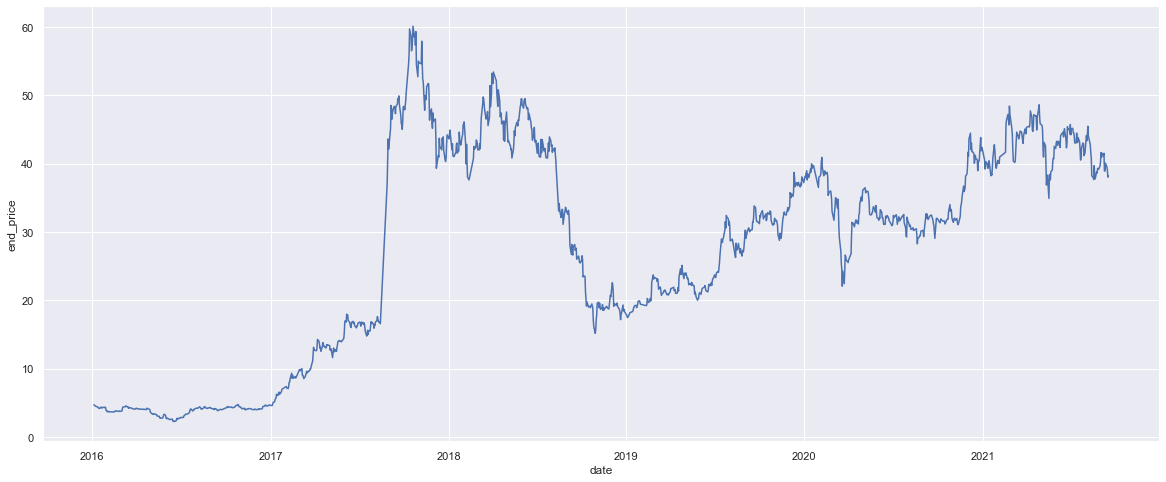

In [4]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.lineplot(data=df, x="date", y="end_price")

In [5]:
df_year = df.groupby(by='year', as_index=False).mean()
df_month = df.groupby(by='month', as_index=False).mean()
df_day = df.groupby(by='day', as_index=False).mean()
df_weekday = df.groupby(by='weekday', as_index=False).mean()

<AxesSubplot:xlabel='year', ylabel='end_price'>

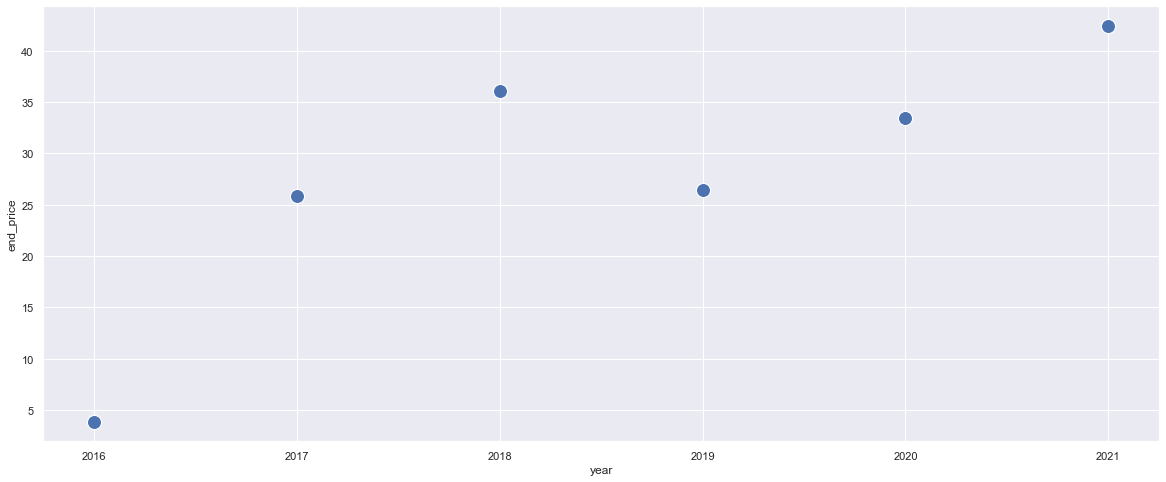

In [6]:
sns.scatterplot(
    data=df_year, x='year', y='end_price', s=200)

<AxesSubplot:xlabel='month', ylabel='end_price'>

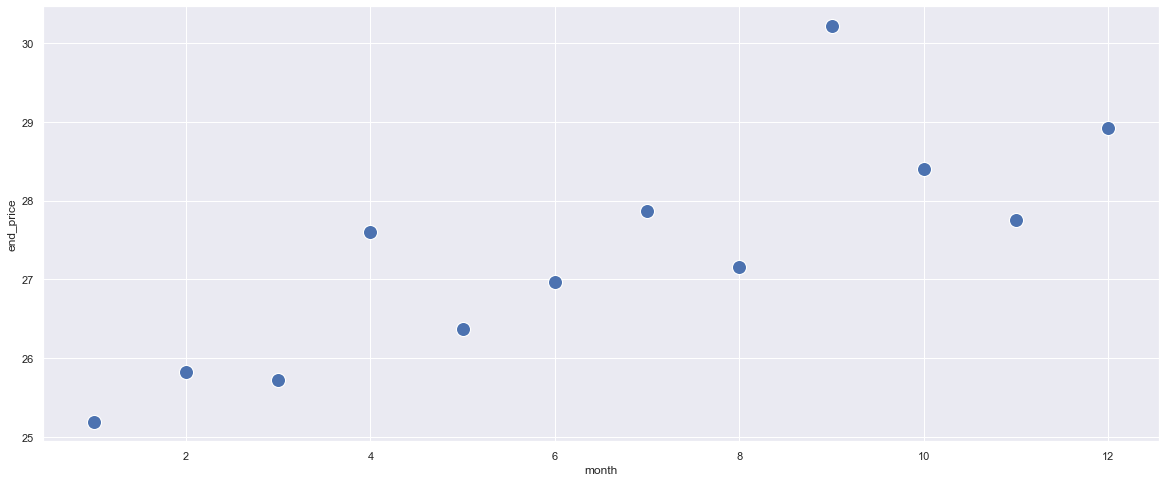

In [7]:
sns.scatterplot(
    data=df_month, x="month", y="end_price", s=200
)

<AxesSubplot:xlabel='day', ylabel='end_price'>

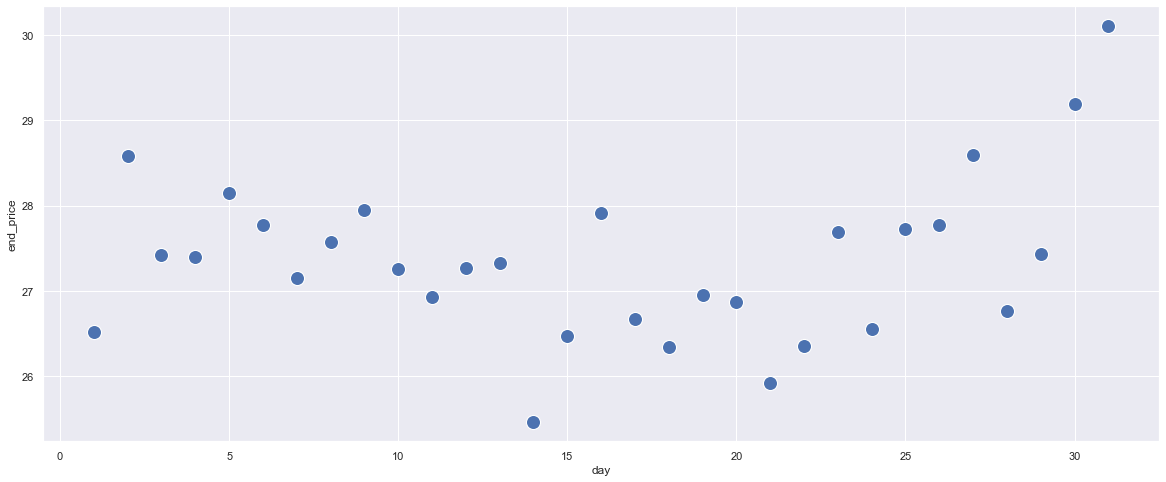

In [8]:
sns.scatterplot(
    data=df_day, x="day", y="end_price", s=200
)

<AxesSubplot:xlabel='weekday', ylabel='end_price'>

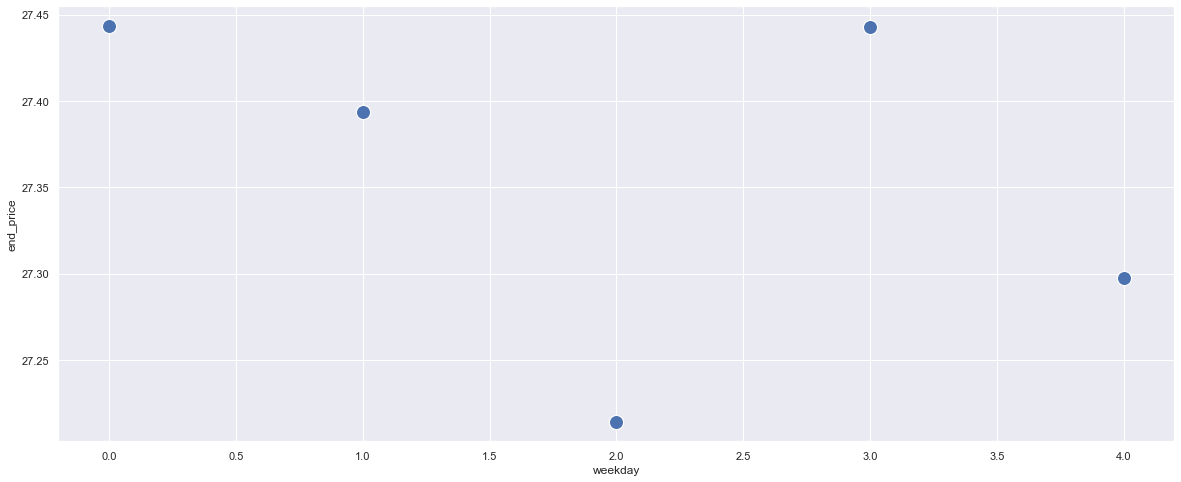

In [9]:
sns.scatterplot(
    data=df_weekday.query('weekday != 5'), x="weekday", y="end_price", s=200
)

<AxesSubplot:>

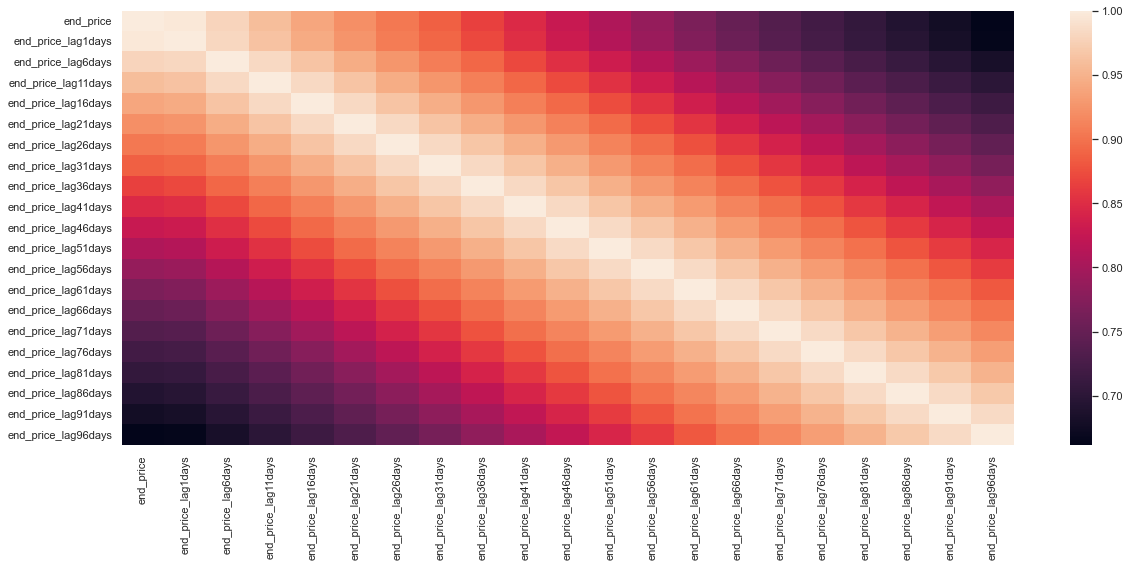

In [10]:
df_for_shift = df[['date', 'end_price']].copy().set_index('date')
df_heat_map = df[['date', 'end_price']].copy().set_index('date')
for i in range(0, 100, 5):
    df_shift = df_for_shift.shift(periods=i+1)
    df_heat_map = df_heat_map.merge(df_shift, left_index=True, right_index=True, how='inner', suffixes=('', '_lag'+ str(i+1) + 'days'))

df_heat_map.dropna(how='any', inplace=True)
df_r_value = df_heat_map.corr(method ='pearson')
sns.heatmap(df_r_value)

In [11]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [12]:
add_datepart(df, 'date', drop=False)

/Users/louisluo/stock_selector/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [13]:
df.head()

,date,volumn,amount,start_price,max_price,min_price,end_price,delta,count,year,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2016-01-04,"3,564,019","16,956,319",4.80,4.84,4.68,4.69,-0.09,924,2016,...,4,0,4,False,False,False,False,False,False,1451865600
1,2016-01-05,"2,504,182","11,692,096",4.69,4.74,4.62,4.63,-0.06,752,2016,...,5,1,5,False,False,False,False,False,False,1451952000
2,2016-01-06,"4,528,184","20,886,563",4.63,4.69,4.57,4.60,-0.03,"1,073",2016,...,6,2,6,False,False,False,False,False,False,1452038400
3,2016-01-07,"6,462,223","29,128,814",4.60,4.63,4.45,4.49,-0.11,"1,275",2016,...,7,3,7,False,False,False,False,False,False,1452124800
4,2016-01-08,"3,729,252","16,547,177",4.32,4.49,4.32,4.49,0.00,829,2016,...,8,4,8,False,False,False,False,False,False,1452211200


In [14]:
df_y = df[['date', 'end_price']].copy().set_index('date').shift(periods=-30)
df_y.columns = ['30days_end_price']
df = df.merge(df_y, left_on='date', right_index=True, how='inner')

In [15]:
import re
def filter_symbol(s):
    regex = re.compile('[^0-9]')
    return regex.sub('', str(s))

In [16]:
data = df[['volumn', 'amount', 'start_price', 'max_price', 'min_price', 'end_price', 'delta', 'count', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']].copy()
# data[['volumn', 'amount', 'delta', 'count']] = data[['volumn', 'amount', 'delta', 'count']].apply(filter_symbol)
data['volumn'] = data['volumn'].apply(filter_symbol).astype(int)
data['amount'] = data['amount'].apply(filter_symbol).astype(int)
data['delta'] = data['delta'].apply(filter_symbol).astype(int)
data['count'] = data['count'].apply(filter_symbol).astype(int)

x_train = data.iloc[:-100]
y_train = df[['30days_end_price']].iloc[:-100]

x_test = data.iloc[-100:]
y_test = df[['30days_end_price']].iloc[-100:]

In [17]:
clf = xgb.XGBRegressor()
clf.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
y_train_predict = clf.predict(x_train)
y_test_predict = clf.predict(x_test)

predict = np.concatenate((y_train_predict, y_test_predict), axis=0)

df_predict = df[['date']].copy().set_index('date')
df_predict['predict'] = predict
df_predict = df_predict.shift(periods=30)


df = df.merge(df_predict, left_on='date', right_on='date', how='outer')


<AxesSubplot:xlabel='date', ylabel='end_price'>

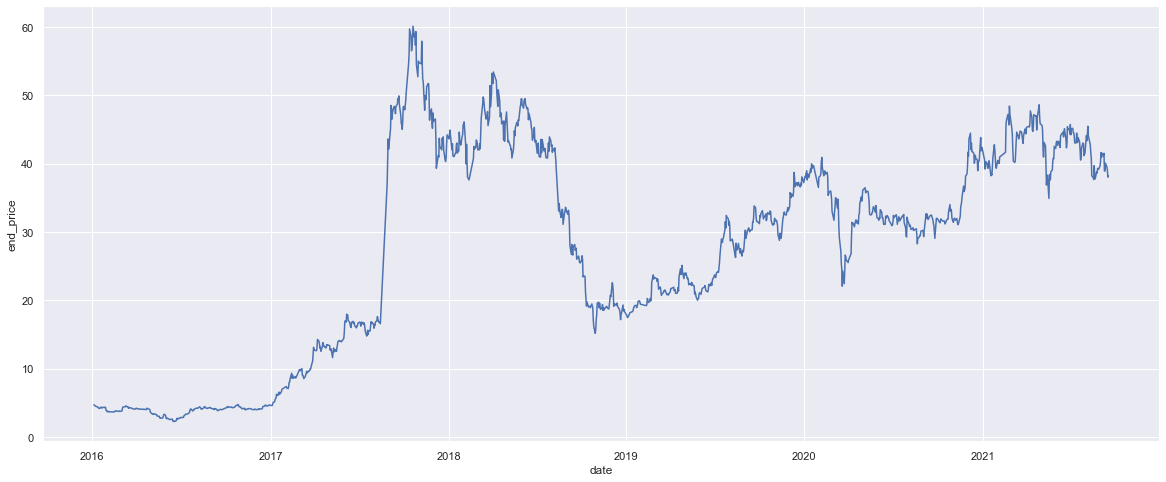

In [19]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.lineplot(data=df, x="date", y="end_price")

<AxesSubplot:xlabel='date', ylabel='end_price'>

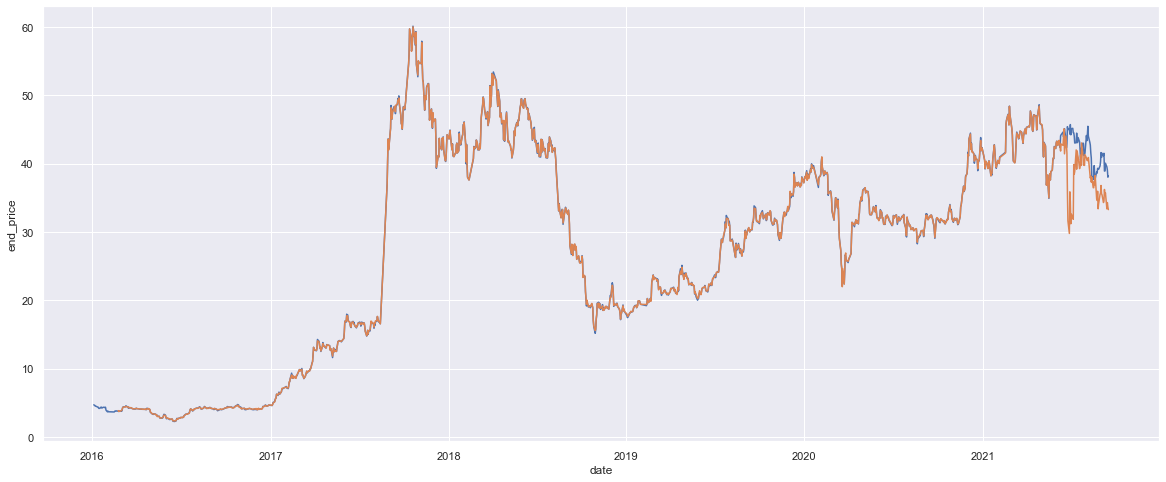

In [20]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.lineplot(data=df, x="date", y="end_price")
sns.lineplot(data=df, x="date", y="predict")

<AxesSubplot:xlabel='date', ylabel='end_price'>

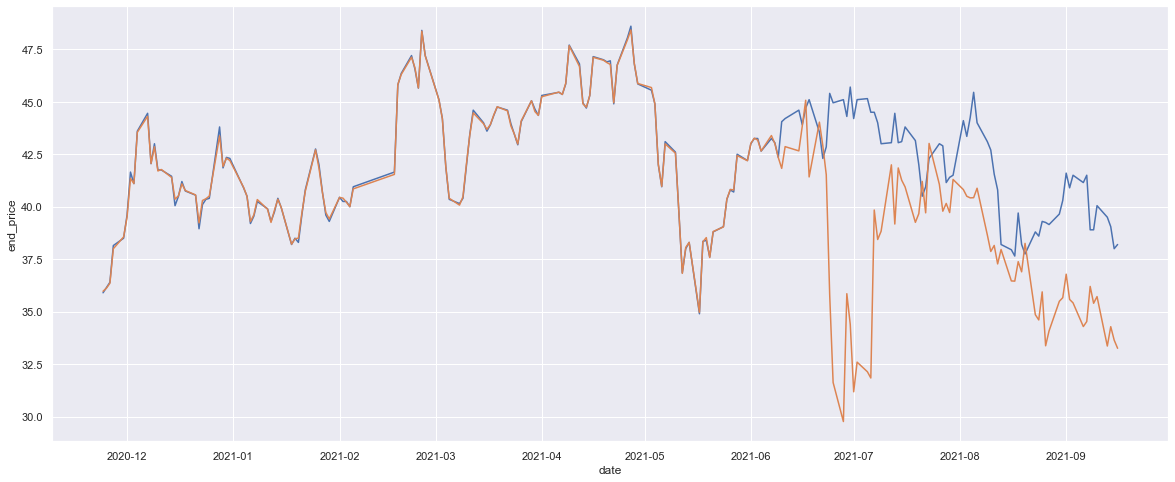

In [21]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.lineplot(data=df[-200:], x="date", y="end_price")
sns.lineplot(data=df[-200:], x="date", y="predict")

<AxesSubplot:>

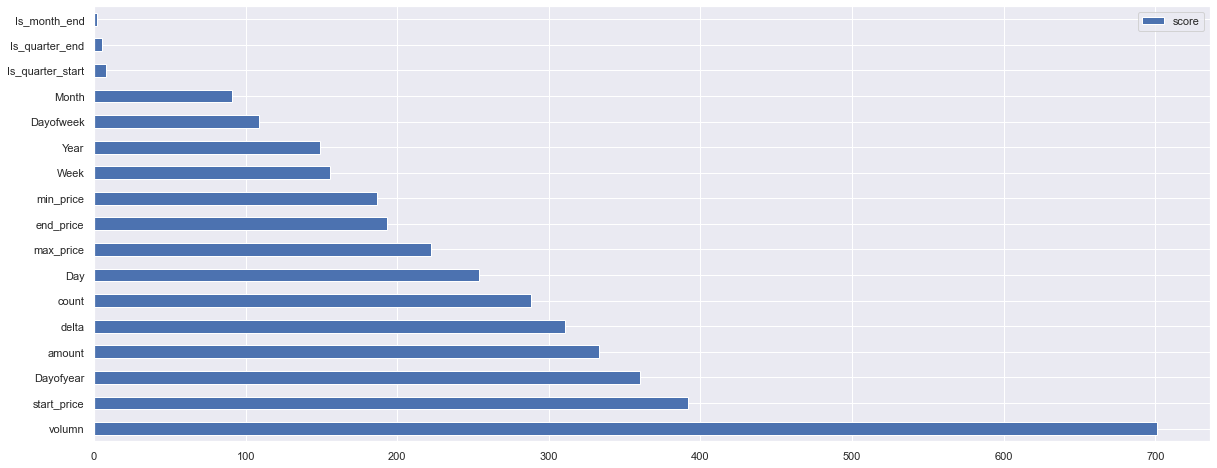

In [22]:
feature_important = clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

In [27]:
df_dayofyear = df.groupby(by='Dayofyear', as_index=False).mean()

<AxesSubplot:xlabel='Dayofyear', ylabel='end_price'>

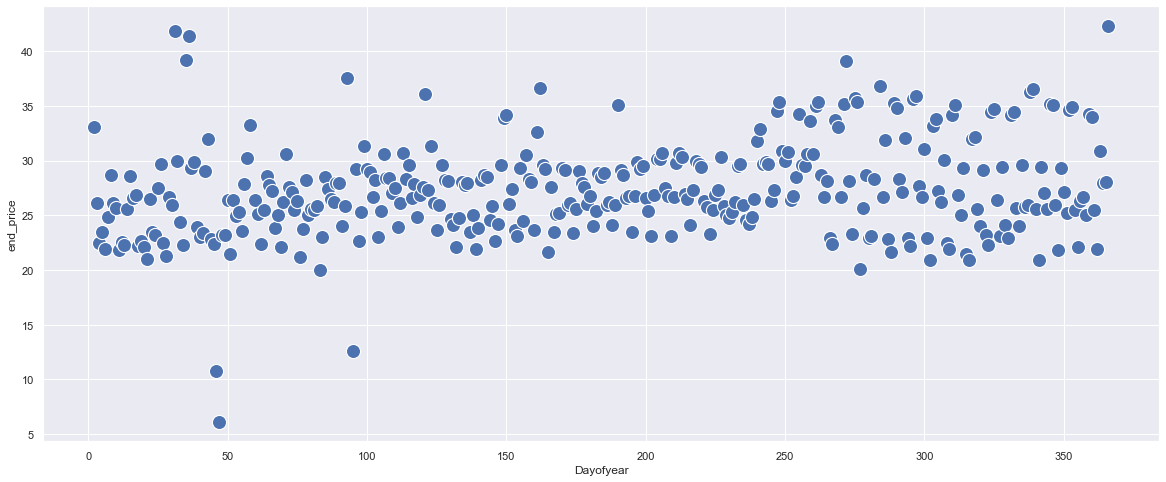

In [28]:
sns.scatterplot(
    data=df_dayofyear, x="Dayofyear", y="end_price", s=200
)